In [2]:
import pandas as pd
import numpy as np
import yaml
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
from scipy.fft import fft
from scipy.stats import boxcox
from scipy.special import inv_boxcox
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, MinMaxScaler, PowerTransformer, RobustScaler
from sklearn.linear_model import LinearRegression
import openpyxl
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score,precision_score, f1_score, mean_squared_error
import xgboost as xgb
import optuna
import talib
import json
import pickle
import torch
import os
import logging
from scipy.stats.mstats import winsorize
from plotly.subplots import make_subplots
import seaborn as sns
from imblearn.over_sampling import SMOTEN
import smogn
import warnings

In [3]:
print(torch.backends.mps.is_available())

True


In [4]:
def load_yaml(file):
    import yaml
    with open(file, 'r') as f:
        config = yaml.safe_load(f)
    return config
    



In [5]:
config = load_yaml('../config_xgRegSlope.yaml')

In [6]:
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)

log_dir = "logs"
os.makedirs(log_dir, exist_ok=True)
log_file = "logstraining_logs_xgRegSlope.txt"
log_file_path = os.path.join(log_dir, log_file)
print(log_file_path)
logging.basicConfig(
    filename=log_file_path,
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S"
)

logging.info("Logging started")

logs/logstraining_logs_xgRegSlope.txt


In [7]:
all_trading_data_dfs = []
sheet_names = ['5minData11-6-2014', '5minData12-17-2019']
for sheet in sheet_names:
    temp_df = pd.read_excel(config['all_data_excel_path'], sheet_name=sheet)
    all_trading_data_dfs.append(temp_df)
all_trading_data = pd.concat(all_trading_data_dfs, ignore_index=True)

# Load 5 min data
all_trading_data['Date'] = pd.to_datetime(all_trading_data['Date'])

In [8]:
##### Set the Date Start and End for the filtering of trading data
train_start_date = pd.to_datetime('2023-01-01')
train_end_date = pd.to_datetime('2023-12-31')
trading_data_raw = all_trading_data[(all_trading_data['Date'] >= train_start_date) & (all_trading_data['Date'] <= train_end_date)]
trading_data_raw = trading_data_raw.reset_index(drop=True)
trading_data_raw.drop(columns=['Symbol'], inplace=True)
trading_data_raw.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19430 entries, 0 to 19429
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    19430 non-null  datetime64[ns]
 1   Open    19430 non-null  float64       
 2   High    19430 non-null  float64       
 3   Low     19430 non-null  float64       
 4   Close   19430 non-null  float64       
 5   Volume  19430 non-null  int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 910.9 KB


In [9]:
fourier_lookback_window = config['fourier_lookback_window']
fourier_n_components = config['fourier_n_components']
m_bars = config['m_future']

In [23]:
def calculate_bollinger_bands(data, window_size, num_std_dev):
    rolling_mean = data['Close'].rolling(window=window_size).mean()
    rolling_std = data['Close'].rolling(window=window_size).std()
    data['BOLLBU'] = rolling_mean + (rolling_std * num_std_dev)
    data['BOLLBM'] = rolling_mean
    data['BOLLBL'] = rolling_mean - (rolling_std * num_std_dev)
    
    return data

def calculate_donchn_bands(data, window_size):
    data['DONCH_U'] = data['High'].rolling(window=window_size).max()
    data['DONCH_L'] = data['Low'].rolling(window=window_size).min()
    
    return data
    
def calculate_tchr(data):
    period = config['tchr_period']
    retracement = config['tchr_retracement']
    adj = config['tchr_adj']
    range = config['tchr_range']

    if range == 'highlow':
        data['TCHR_U'] = talib.MAX(data['High'], timeperiod=period) + adj
        data['TCHR_L'] = talib.MIN(data['Low'], timeperiod=period) - adj
    elif range == 'close':
        data['TCHR_U'] = talib.MAX(data['Close'], timeperiod=period) + adj
        data['TCHR_L'] = talib.MIN(data['Close'], timeperiod=period) - adj
    
    #calculate retracement
    if retracement == "long":
        data['TCHR'] = (data['Close'] - data['TCHR_L']) / (data['TCHR_U'] - data['TCHR_L'])
    elif retracement == "short":
        data['TCHR'] = (data['TCHR_U'] - data['Close']) / (data['TCHR_U'] - data['TCHR_L'])
    
    return data
    
def calculate_adwm(data):
    period = config['adwm_period']
    data['Previous_Close']= data['Close'].shift(1)
    data['TRH'] = data[['High', 'Previous_Close']].max(axis=1)
    data['TRL'] = data[['Low', 'Previous_Close']].min(axis=1)

    data['ADWM_AD'] = 0.0
    data.loc[data['Close'] > data['Previous_Close'], 'ADWM_AD'] = (data['Close'] - data['TRL'])
    data.loc[data['Close'] < data['Previous_Close'], 'ADWM_AD'] = (data['Close'] - data['TRH'])

    data['ADWM'] = data['ADWM_AD']

    data['ADWMMA'] = data['ADWM'].rolling(window=period).mean()

    return data

def calculate_si(row, prev_row, limit):
    if pd.isna(prev_row['Close']):
        return 0
    c = row['Close']
    c_prev = prev_row['Close']
    o = row['Open']
    o_prev = prev_row['Open']
    return (50 * ((c - c_prev) + (0.5 * (c - o)) + (0.25 * (c_prev - o_prev))) / limit)

def calculate_WASI(data):
    wasi_limit = config['wasi_limit']
    data['SI'] = data.apply(lambda row: calculate_si(row, data.shift(1).loc[row.name], wasi_limit), axis=1)
    data['WASI'] = data['SI']
    return data

def calculate_ATR(data):
    atr_period = config['atr_period']
    atr_ma = config['atr_ma']
    data['ATR'] = talib.ATR(data['High'], data['Low'], data['Close'], timeperiod=atr_period)
    data['ADJATR'] = talib.SMA(data['ATR'], timeperiod=atr_ma)
    return data


def compute_volatility_momentum(df, price_col='Close', vol_window=14, mom_window=10):
    """
    Computes rolling volatility and momentum for a given price column.

    Parameters:
        df (pd.DataFrame): DataFrame containing historical price data.
        price_col (str): Column name of the closing price.
        vol_window (int): Window size for rolling volatility calculation.
        mom_window (int): Window size for momentum calculation.

    Returns:
        pd.DataFrame: DataFrame with added 'Volatility' and 'Momentum' features.
    """

    # Ensure price column exists
    if price_col not in df.columns:
        raise ValueError(f"Column '{price_col}' not found in DataFrame")

    # 🔹 Compute Log Returns (for better volatility calculation)
    df['Log_Returns'] = np.log(df[price_col] / df[price_col].shift(1))

    # 🔹 Compute Rolling Volatility (Standard Deviation of Log Returns)
    df['Volatility'] = df['Log_Returns'].rolling(window=vol_window).std()

    # 🔹 Compute Momentum (Rate of Change in Price)
    df['Momentum'] = df[price_col].pct_change(periods=mom_window) * 100

    # 🔹 Drop NaN values from rolling computations
    #df.dropna(inplace=True)

    return df


def compute_fourier_df(value_series, n_components=10):
    fft_result = np.fft.fft(value_series)
    real = fft_result.real[:n_components]
    imag = fft_result.imag[:n_components]
    mag = np.abs(fft_result)[:n_components]

    return real, imag, mag

def get_fourier_columns():
    return [f'fourier_real_{j+2}' for j in range(fourier_n_components-1)] + [f'fourier_imag_{j+2}' for j in range(fourier_n_components-1)] + [f'fourier_mag_{j+2}' for j in range(fourier_n_components-1)]   

def transform_features(df):
    close_diff_features = config['Close_Diff_Features'].split(',')
    df[close_diff_features] = df[close_diff_features].sub(df['Close'], axis=0).div(df['Close'], axis=0)
    return df

def get_all_training_features():
    training_features = config['training_features'].split(',')
    fourier_cols = get_fourier_columns()
    return training_features + fourier_cols

def normalize_timegaps(df, time_gap_threshold=300):
    df = df.copy()
    features = ['Open', 'High', 'Low', 'Close']
    df['time_delta'] = df['Date'].diff().dt.total_seconds()
    df['time_delta'] = df['time_delta'].fillna(df['time_delta'].median())
    df['time_gap_flag'] = df['time_delta'] > time_gap_threshold
    gap_indices = df.index[df['time_gap_flag']].tolist()
    for p in gap_indices:
        if p > 0: # ensure p-1 exist
            jump_value = df.loc[p, 'Close'] - df.loc[p-1, 'Close']
            df.loc[:p-1, features] += jump_value
    return df

In [11]:
def add_new_features_df(data):
    fourier_lookback_window = config['fourier_lookback_window']
    fourier_n_components = config['fourier_n_components']

    #data['Date'] = pd.to_datetime(data['Date'])
    #print(f"bolband period : {config['bolband_period']}")
    bolband_period = config['bolband_period']
    bolband_width = config['bolband_width']
    upper, middle, lower = talib.BBANDS(data['Close'], timeperiod=bolband_period, nbdevup=bolband_width, nbdevdn=bolband_width, matype=0)
    data['BOLLBU'] = upper
    data['BOLLBM'] = middle
    data['BOLLBL'] = lower
    #data = calculate_bollinger_bands(data, int(config['bolband_period']), int(config['bolband_width']))

    # Calculate DONCHN Bands
    donchn_period = config['donchn_period']
    data['DONUP'] = talib.MAX(data['High'], timeperiod=donchn_period)

    data['DONLOW'] = talib.MIN(data['Low'], timeperiod=donchn_period)

    data['DONMID'] = (data['DONLOW'] + data['DONUP']) / 2

    data['MA20'] = talib.SMA(data['Close'], timeperiod=20)

    data['MA50'] = talib.SMA(data['Close'], timeperiod=50)

    data['MA100'] = talib.SMA(data['Close'], timeperiod=100)

    data['EMA20'] = talib.EMA(data['Close'], timeperiod=20)

    # Calculate the pivot points
    data['PVPT'] = (data['High'] + data['Low'] + data['Close']) / 3
    data['PVPTR1'] = (2 * data['PVPT']) - data['Low']

    data['PVPTR2'] = data['PVPT'] + data['High'] - data['Low']

    data['PVPTR3'] = data['High'] + 2 * (data['PVPT'] - data['Low'])

    data['PVPTS1'] = (2 * data['PVPT']) - data['High']

    data['PVPTS2'] = data['PVPT'] - (data['High'] - data['Low'])

    data['PVPTS3'] = data['Low'] - 2 * (data['High'] - data['PVPT'])

    data = calculate_tchr(data)

    data = calculate_adwm(data)

    data = calculate_WASI(data)

    volume_ma_period = config['volume_ma_period']

    data['VOLMA'] = talib.SMA(data['Volume'], timeperiod=volume_ma_period)

    data = calculate_ATR(data)

    data['DayofWeek'] = data['Date'].dt.dayofweek

    data['DayofWeek'] = data['DayofWeek'].astype('category')

    data = compute_volatility_momentum(data, price_col='Close', vol_window=config['volatility_period'], mom_window=config['momentum_period'])

    # Add fourier columns to the df
    for i in range(fourier_n_components):
        data[f'fourier_real_{i+1}'] = np.nan
        data[f'fourier_imag_{i+1}'] = np.nan
        data[f'fourier_mag_{i+1}'] = np.nan

    features = []
    epsilon = 1e-5
    #print(f"fourier window - 1 : {fourier_lookback_window - 1}")
    for i in range(len(data)):
        if i >= fourier_lookback_window - 1:
            #print("entered point 1")
            close_window = data['Close'].iloc[i - fourier_lookback_window + 1: i + 1].values
            real, imag, mag = compute_fourier_df(close_window, n_components=fourier_n_components)

            for j in range(fourier_n_components):
                data.iloc[i, data.columns.get_loc(f'fourier_real_{j+1}')] = real[j]
                data.iloc[i, data.columns.get_loc(f'fourier_imag_{j+1}')] = imag[j]
                data.iloc[i, data.columns.get_loc(f'fourier_mag_{j+1}')] = mag[j]
                #print(data.loc[i, 'Date'])
    


    # Add the time of day feature to the trading data

    # Define max time of day in minutes
    MAX_TIME_MINUTES = 1440
    data['Minutes_Passed'] = (data['Date'].dt.hour* 60) + data['Date'].dt.minute
    data['TimeOfDay_Group'] = (data['Minutes_Passed'] // 5).astype('int')
    data['Sine_TimeOfDay'] = np.sin(2 * np.pi * data['TimeOfDay_Group'] / MAX_TIME_MINUTES)
    data['Cosine_TimeOfDay'] = np.cos(2 * np.pi * data['TimeOfDay_Group'] / MAX_TIME_MINUTES)
    data['Take_Profit_Level'] = (data['Close'] * config['atr_multiplier'] * data['ADJATR'])
    data['time_delta'] = data['Date'].diff().dt.total_seconds()
    data['time_delta'].fillna(data['time_delta'].median(), inplace=True)
    #print("Feature df info : ")
    #print(data.info())

    #print(f"Last row after adding features : ")
    #print(data.tail())
    return data


In [34]:
trading_data_time_normalized = normalize_timegaps(trading_data_raw)

In [35]:
toplot_df = trading_data_time_normalized

fig = make_subplots(rows=2, cols=1, shared_xaxes=True, 
                    vertical_spacing=0.1,
                    subplot_titles=("CandleStick Chart Norm", "CandleStick Chart"))
fig.add_trace(
    go.Candlestick(
        x=toplot_df['Date'], 
        open=toplot_df['Open'], 
        high=toplot_df['High'], 
        low=toplot_df['Low'], 
        close=toplot_df['Close'],
        name='OHLC Norm'
        ), row=1, col=1
)

fig.add_trace(
    go.Candlestick(
        x=trading_data_raw['Date'], 
        open=trading_data_raw['Open'], 
        high=trading_data_raw['High'], 
        low=trading_data_raw['Low'], 
        close=trading_data_raw['Close'],
        name='OHLC'
        ), row=2,col=1
)

fig.update_layout(
    title='CandleStick chart of time normalized',
    xaxis=dict(type="date", 
               rangebreaks=[
                   dict(bounds=["sat", "mon"]),
                   dict(bounds=[16,9.5], pattern='hour')
               ]              
            ),
    xaxis_rangeslider_visible=False,
    height=600,
    hovermode='x unified'
)



fig.update_xaxes(matches='x')

fig.show()

In [36]:

def calculate_label(data):

# Define the threshold for buy and sell signals
    
    buy_powers = []
    sell_powers = []
    n=config['bars_no_to_wait']
    for i in range(len(data)):
        current_close = data.loc[i, "Close"]

        future_closes = data.loc[i+1: i+n+1, "Close"].values

        if len(future_closes) == 0:
            buy_powers.append(0)
            sell_powers.append(0)
            continue
        future_close_max = max(future_closes) 
        future_close_min = min(future_closes)
        max_high = future_close_max - current_close
        min_high = current_close - future_close_min
        max_high_idx = list(future_closes).index( future_close_max)
        min_high_idx = list(future_closes).index( future_close_min)

        if max_high_idx == (len(future_closes) - 1): #when max value is at the last of window
            buy_retr_penalty = 0
        else:
            buy_retr_penalty = future_close_max - min(future_closes[max_high_idx+1:])
        max_down_below = max(0, current_close - future_close_min)
        penalty_buy = buy_retr_penalty + max_down_below
        buy_power = max(0, max_high - penalty_buy)

        if min_high_idx == (len(future_closes) - 1): 
            sell_retr_penalty = 0
        else:
            sell_retr_penalty = max(future_closes[min_high_idx+1:]) - future_close_min
        max_up_above = max(0, future_close_max - current_close)
        penalty_sell = sell_retr_penalty + max_up_above
        sell_power = max(0, min_high - penalty_sell)

        buy_powers.append(buy_power)
        sell_powers.append(sell_power)

    data['BuyPower'] = buy_powers
    data['SellPower'] = sell_powers
        

    return data

In [37]:
trading_data_with_power = calculate_label(trading_data_time_normalized)
trading_data_with_power.dropna(inplace=True)

In [38]:
trading_data_with_power[['BuyPower']].describe()

BuyPower
count  19430.000000
mean       0.336215
std        0.643031
min        0.000000
25%        0.000000
50%        0.000000
75%        0.448075
max        9.050000

In [39]:
trading_data_with_power[['SellPower']].describe()

SellPower
count  19430.000000
mean       0.306297
std        0.667021
min        0.000000
25%        0.000000
50%        0.000000
75%        0.278700
max        9.600000

In [40]:
trading_data_with_power[(trading_data_with_power['BuyPower'] > 0.5) | (trading_data_with_power['SellPower'] > 0.5)].count()
#trading_data_with_slope.count()

Date             8481
Open             8481
High             8481
Low              8481
Close            8481
Volume           8481
time_delta       8481
time_gap_flag    8481
BuyPower         8481
SellPower        8481
dtype: int64

In [41]:
trading_data_with_features = add_new_features_df(trading_data_with_power.copy())

/var/folders/ns/6tgyd_dx5lq_3chvzvfdm1sr0000gp/T/ipykernel_27664/1900632745.py:96: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





In [42]:
pd.set_option("display.max_columns", None)  # Show all columns
pd.set_option("display.max_rows", None)  # Show all rows
trading_data_with_features.describe().T

count                           mean  \
Date                 19430  2023-07-02 15:44:07.936180992   
Open               19430.0                     468.036754   
High               19430.0                     468.267182   
Low                19430.0                     467.801705   
Close              19430.0                     468.039982   
Volume             19430.0                  748430.984354   
time_delta         19430.0                    1602.027792   
BuyPower           19430.0                       0.336215   
SellPower          19430.0                       0.306297   
BOLLBU             19411.0                     469.038549   
BOLLBM             19411.0                     468.057158   
BOLLBL             19411.0                     467.075768   
DONUP              19411.0                     469.093305   
DONLOW             19411.0                     466.954038   
DONMID             19411.0                     468.023672   
MA20               19411.0                     468.057158   
MA50               19381.0                     468.086562   
MA100              19331.0                     468.136237   
EMA20              19411.0                     468.057532   
PVPT               19430.0                     468.036289   
PVPTR1             19430.0                     468.270874   
PVPTR2             19430.0                     468.501766   
PVPTR3             19430.0                     468.736351   
PVPTS1             19430.0                     467.805397   
PVPTS2             19430.0                     467.570813   
PVPTS3             19430.0                     467.339921   
TCHR_U             19331.0                     475.555742   
TCHR_L             19331.0                     460.534923   
TCHR               19331.0                       0.515323   
Previous_Close     19429.0                     468.039603   
TRH                19430.0                     468.267304   
TRL                19430.0                     467.801533   
ADWM_AD            19430.0                       0.005714   
ADWM               19430.0                       0.005714   
ADWMMA             19417.0                       0.005903   
SI                 19430.0                       0.081289   
WASI               19430.0                       0.081289   
VOLMA              19421.0                  747670.370347   
ATR                19416.0                       0.465729   
ADJATR             19397.0                       0.465537   
Log_Returns        19429.0                       0.000005   
Volatility         19416.0                       0.000604   
Momentum           19420.0                       0.005909   
fourier_real_1     19331.0                    46813.62368   
fourier_imag_1     19331.0                            0.0   
fourier_mag_1      19331.0                    46813.62368   
fourier_real_2     19331.0                      -0.185167   
fourier_imag_2     19331.0                       4.326233   
fourier_mag_2      19331.0                       61.55453   
fourier_real_3     19331.0                      -0.128774   
fourier_imag_3     19331.0                       2.168186   
fourier_mag_3      19331.0                      31.372622   
fourier_real_4     19331.0                       -0.13242   
fourier_imag_4     19331.0                       1.435442   
fourier_mag_4      19331.0                      20.245386   
fourier_real_5     19331.0                      -0.135737   
fourier_imag_5     19331.0                       1.079201   
fourier_mag_5      19331.0                      14.764448   
fourier_real_6     19331.0                      -0.137131   
fourier_imag_6     19331.0                       0.859639   
fourier_mag_6      19331.0                       12.21928   
fourier_real_7     19331.0                      -0.135077   
fourier_imag_7     19331.0                        0.71357   
fourier_mag_7      19331.0                      10.181927   
fourier_real_8     19331.0                      -0.13588

In [43]:
#trading_data['Date'] = pd.to_datetime(trading_data['Date'])
fig = go.Figure(data=[go.Candlestick(x=trading_data_with_features['Date'], open=trading_data_with_features['Open'], high=trading_data_with_features['High'], low=trading_data_with_features['Low'], close=trading_data_with_features['Close'])])
fig.update_layout(title='CandleStick Chart SPY', xaxis_title='Date', yaxis_title='Price', xaxis_rangeslider_visible=False, yaxis=dict(fixedrange=False), xaxis=dict(type='category'))
buy_signals = trading_data_with_features[trading_data_with_features['BuyPower'] > 0.5]
sell_signals = trading_data_with_features[trading_data_with_features['SellPower'] > 0.5]
fig.add_trace(go.Scatter(x=buy_signals['Date'], y=buy_signals['Low'], mode='markers', name='Buy Signal', marker=dict(color='blue', size=10), text=[f"Slope: {slope:.3f}" for slope in buy_signals['BuyPower']]))
fig.add_trace(go.Scatter(x=sell_signals['Date'], y=sell_signals['High'], mode='markers', name='Sell Signal', marker=dict(color='yellow', size=10), text=[f"Slope: {slope:.3f}" for slope in sell_signals['SellPower']]))
fig.show()

####  Transform Features that have to be differenced from Close

In [44]:
trading_data_transformed = transform_features(trading_data_with_features.copy())

In [45]:
all_training_features = get_all_training_features()

#### Do Robust scaling on all training features

In [46]:
trading_data_scaled = trading_data_transformed.copy()
rscaler = RobustScaler()
trading_data_scaled[all_training_features] = rscaler.fit_transform(trading_data_scaled[all_training_features])

#### Use Clipping (Winsorization) to Limit Extreme Values

In [47]:
def winsor_features(df, features, lower=5, upper=95):
    df = df.copy()
    lower_limit = lower / 100
    upper_limit = (100 - upper) / 100
    for feature in features:
        df[feature] = winsorize(df[feature], limits=(lower_limit, upper_limit))

    return df

In [48]:
### Set lower limit and upper limit for winsor
lower_limit_winsor = 5
upper_limit_Winsor = 95
### Apply the winsorization for all training features
trading_data_scaled = winsor_features(trading_data_scaled, all_training_features, lower=lower_limit_winsor, upper=upper_limit_Winsor)



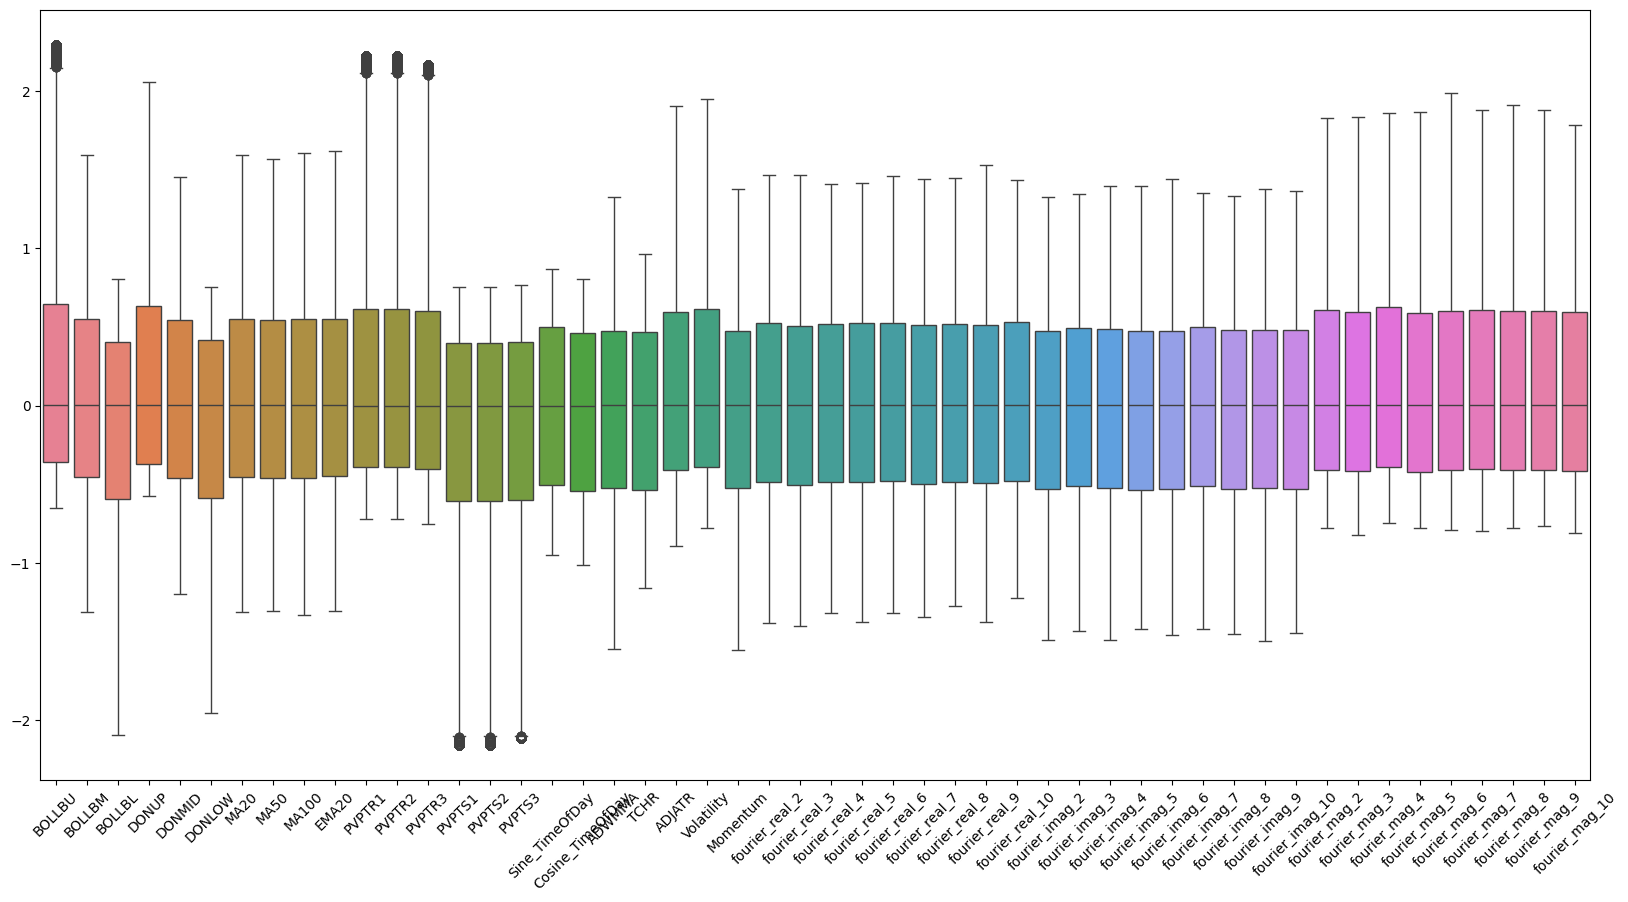

In [49]:
plt.figure(figsize=(20, 10))
sns.boxplot(data=trading_data_scaled[all_training_features])
plt.xticks(rotation=45)
plt.show()

#### UnderSampling and Oversampling Data

In [50]:
do_smote = False
if do_smote:
    epsilon = 0.05

    X = trading_data_scaled[all_training_features]
    y = trading_data_scaled['Close_Slope']

    # Balance dataset by reducing near zero slopes
    extreme_values = trading_data_scaled[np.abs(y) > epsilon]
    near_zero_values = trading_data_scaled[np.abs(y) <= epsilon].sample(frac=0.3, random_state=42)
    balanced_data = pd.concat([extreme_values, near_zero_values]).reset_index(drop=True)
    print(f"Balanced data before smogn shape: {balanced_data.shape}")
    balanced_data['Close_Slope'].describe()
    features_with_labels = all_training_features + ['Close_Slope']
    balanced_data = balanced_data[features_with_labels]

    # Apply SMOGN
    smote_balanced_data = smogn.smoter(
        data=balanced_data, 
        y='Close_Slope', 
        samp_method='balance'
    )
    print(f"Balanced data after smogn shape: {smote_balanced_data.shape}")
    #X_balanced = balanced_data[all_training_features]
    #y_balanced = balanced_data['Close_Slope']

    X = smote_balanced_data[all_training_features]
    y = smote_balanced_data['Close_Slope']

In [232]:
def weighted_loss(preds, dtrain):
    labels = dtrain.get_label()
    residuals = (preds - labels).astype("float")
    weights = np.where(np.abs(labels) > 0.05, 5.0, 1.0)
    grad = 2.0 * residuals * weights
    hess = 2.0 * weights
    return grad, hess

#### Check Weights of buy power and sell power

In [62]:
y = trading_data_scaled[['BuyPower', 'SellPower']]
X = trading_data_scaled[all_training_features]
buying_weight = (y['BuyPower'] > 0).sum() / (y['BuyPower'] == 0).sum()
selling_weight = (y['SellPower'] > 0).sum() / (y['SellPower'] == 0).sum()
print(f"Buying weight: {buying_weight}")
print(f"Selling weight: {selling_weight}")

Buying weight: 0.6222760290556901
Selling weight: 0.4690760623015273


In [60]:
((y['BuyPower'] == 0) & (y['SellPower'] == 0)).sum()

np.int64(5773)

In [63]:
do_weight_balancing = False
if do_weight_balancing:
    epsilon = 0.05
    extreme_values = trading_data_scaled[np.abs(trading_data_scaled['Close_Slope']) > epsilon]
    near_zero_values = trading_data_scaled[np.abs(trading_data_scaled['Close_Slope']) <= epsilon].sample(frac=0.5, random_state=42)
    print(f"Extreme values shape: {extreme_values.shape} and near zero values shape: {near_zero_values.shape}")
    balanced_data = pd.concat([extreme_values, near_zero_values]).reset_index(drop=True)
    print(f"Balanced data shape: {balanced_data.shape} and actual data shape : {trading_data_scaled.shape}")
    X = balanced_data[all_training_features]
    y = balanced_data['Close_Slope']

In [64]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=43)


In [65]:
print(X.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19430 entries, 0 to 19429
Data columns (total 50 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   BOLLBU            19430 non-null  float64
 1   BOLLBM            19430 non-null  float64
 2   BOLLBL            19430 non-null  float64
 3   DONUP             19430 non-null  float64
 4   DONMID            19430 non-null  float64
 5   DONLOW            19430 non-null  float64
 6   MA20              19430 non-null  float64
 7   MA50              19430 non-null  float64
 8   MA100             19430 non-null  float64
 9   EMA20             19430 non-null  float64
 10  PVPTR1            19430 non-null  float64
 11  PVPTR2            19430 non-null  float64
 12  PVPTR3            19430 non-null  float64
 13  PVPTS1            19430 non-null  float64
 14  PVPTS2            19430 non-null  float64
 15  PVPTS3            19430 non-null  float64
 16  Sine_TimeOfDay    19430 non-null  float6

In [66]:


#convert data to d matrix to use with xgb
enab_cat = False
dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=False )
dtest = xgb.DMatrix(X_test, label=y_test, enable_categorical=False)

In [68]:
num_boosting_rounds = 20000
##### Implement initial training of the model   
learning_rate = 0.01
starting_tree_method = 'approx'
#metric can be mlogloss, auc, merror etc
metric = 'rmse'

base_params = {
    'objective': 'reg:squarederror',
    'eval_metric': metric,
    'learning_rate': learning_rate
}

params = {
    'learning_rate': learning_rate,
    'tree_method': starting_tree_method
}

params.update(base_params)

In [69]:
#model = xgb.train(params=params, dtrain=dtrain, num_boost_round=num_boosting_rounds, evals=[(dtrain, 'train')], early_stopping_rounds=50)

In [74]:
##### CReate the objective function for optuna to tune tree parameters

def objective(trial):
    #print("Point 0")
    params = {
        'tree_method' : trial.suggest_categorical('tree_method', ['approx', 'hist']) , 
        'gamma': trial.suggest_float('gamma', 1e-2, 10),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'eta': trial.suggest_loguniform('eta', 0.01, 0.3),
        'min_child_weight': trial.suggest_float('min_child_weight', 1, 250),
        'subsample': trial.suggest_float('subsample', 0.1, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'lambda': trial.suggest_float('lambda', 0.001, 25), 
        'alpha': trial.suggest_float('alpha', 0.001, 10),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', min(buying_weight, selling_weight), max(buying_weight, selling_weight))
    }
    params.update(base_params)
    #thresholds = [trial.suggest_float(f'threshold_{i}', 0.1, 0.9) for i in ]
    pruning_callback = optuna.integration.XGBoostPruningCallback(trial, f'test-{metric}')
    evals_result = {}
    #print("Point 1")
    #print(dtrain)
    xgb_model = xgb.train(params=params, dtrain=dtrain, num_boost_round=num_boosting_rounds, 
                          evals=[(dtest, 'test')],
                          early_stopping_rounds=50,
                          verbose_eval=False,
                          callbacks=[pruning_callback],
                          evals_result=evals_result
                        )
    #print("Point 2")
    preds = xgb_model.predict(dtest)
    rmse_buy = mean_squared_error(y_test['BuyPower'], preds[:, 0]) ** 0.5
    rmse_sell = mean_squared_error(y_test['SellPower'], preds[:, 1]) ** 0.5
    #rmse = np.sqrt(np.mean((preds - y_test.values) ** 2))
    rmse = (rmse_buy + rmse_sell) / 2
    #print("Point 3")
    print(f"Trial {trial.number}: Best iteration = {xgb_model.best_iteration}, test rmse = {rmse}")

    return rmse

In [75]:

study = optuna.create_study(direction='minimize') # for metric auc its maximuze, and for mlogloss its minimie
study.optimize(objective, n_trials=100)

# Get the best parameters
print(f" Best parameters: {study.best_params}")
print(f" Best Accuracy: {study.best_value}")

[I 2025-03-03 14:26:41,459] A new study created in memory with name: no-name-f4f4ad17-cc0c-44cf-953e-e96b10ba25c1
/var/folders/ns/6tgyd_dx5lq_3chvzvfdm1sr0000gp/T/ipykernel_27664/497319356.py:9: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[I 2025-03-03 14:26:47,472] Trial 0 finished with value: 0.5836088702983668 and parameters: {'tree_method': 'hist', 'gamma': 1.7189263342681982, 'max_depth': 8, 'eta': 0.25372349276255135, 'min_child_weight': 41.25564802797415, 'subsample': 0.9064101149429438, 'colsample_bytree': 0.5090209131490537, 'lambda': 3.6570366878566722, 'alpha': 5.915754820057372, 'scale_pos_weight': 0.5274063176144016}. Best is trial 0 with value: 0.5836088702983668.


Trial 0: Best iteration = 1343, test rmse = 0.5836088702983668


/var/folders/ns/6tgyd_dx5lq_3chvzvfdm1sr0000gp/T/ipykernel_27664/497319356.py:9: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[I 2025-03-03 14:27:43,334] Trial 1 finished with value: 0.5923069687780997 and parameters: {'tree_method': 'hist', 'gamma': 0.9313373167448671, 'max_depth': 3, 'eta': 0.013872034904284736, 'min_child_weight': 183.30463585159725, 'subsample': 0.28015257447448694, 'colsample_bytree': 0.6142765014944169, 'lambda': 10.125121008032668, 'alpha': 9.347930816023442, 'scale_pos_weight': 0.610807325253871}. Best is trial 0 with value: 0.5836088702983668.


Trial 1: Best iteration = 16314, test rmse = 0.5923069687780997


/var/folders/ns/6tgyd_dx5lq_3chvzvfdm1sr0000gp/T/ipykernel_27664/497319356.py:9: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[I 2025-03-03 14:28:02,588] Trial 2 finished with value: 0.6133436245660715 and parameters: {'tree_method': 'approx', 'gamma': 3.0252756275358816, 'max_depth': 8, 'eta': 0.18100658463483013, 'min_child_weight': 93.10476774318249, 'subsample': 0.3826943331483566, 'colsample_bytree': 0.6645258852033001, 'lambda': 8.847184473676691, 'alpha': 3.1976747015073936, 'scale_pos_weight': 0.5096785413821439}. Best is trial 0 with value: 0.5836088702983668.


Trial 2: Best iteration = 5105, test rmse = 0.6133436245660715


/var/folders/ns/6tgyd_dx5lq_3chvzvfdm1sr0000gp/T/ipykernel_27664/497319356.py:9: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[I 2025-03-03 14:28:08,170] Trial 3 finished with value: 0.6457757701032716 and parameters: {'tree_method': 'hist', 'gamma': 4.777786835298667, 'max_depth': 11, 'eta': 0.12826402652043173, 'min_child_weight': 100.62223370872589, 'subsample': 0.36949681371095516, 'colsample_bytree': 0.650815391005426, 'lambda': 20.15333180120385, 'alpha': 5.79412747859687, 'scale_pos_weight': 0.4707682610628839}. Best is trial 0 with value: 0.5836088702983668.


Trial 3: Best iteration = 2045, test rmse = 0.6457757701032716


/var/folders/ns/6tgyd_dx5lq_3chvzvfdm1sr0000gp/T/ipykernel_27664/497319356.py:9: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[I 2025-03-03 14:28:14,475] Trial 4 finished with value: 0.6483571414578895 and parameters: {'tree_method': 'hist', 'gamma': 4.803052354147057, 'max_depth': 8, 'eta': 0.2612506800763996, 'min_child_weight': 191.56731980751854, 'subsample': 0.37690886338900653, 'colsample_bytree': 0.8789637193646617, 'lambda': 16.21061180089902, 'alpha': 6.331399691762194, 'scale_pos_weight': 0.49438565379709165}. Best is trial 0 with value: 0.5836088702983668.


Trial 4: Best iteration = 2045, test rmse = 0.6483571414578895


/var/folders/ns/6tgyd_dx5lq_3chvzvfdm1sr0000gp/T/ipykernel_27664/497319356.py:9: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[I 2025-03-03 14:28:18,479] Trial 5 pruned. Trial was pruned at iteration 969.
[I 2025-03-03 14:28:22,099] Trial 6 pruned. Trial was pruned at iteration 739.
[I 2025-03-03 14:28:22,122] Trial 7 pruned. Trial was pruned at iteration 0.
[I 2025-03-03 14:28:22,140] Trial 8 pruned. Trial was pruned at iteration 0.
[I 2025-03-03 14:28:22,145] Trial 9 pruned. Trial was pruned at iteration 0.
[I 2025-03-03 14:28:35,624] Trial 10 finished with value: 0.5578066334307414 and parameters: {'tree_method': 'hist', 'gamma': 0.584736754349807, 'max_depth': 5, 'eta': 0.03535730027190165, 'min_child_weight': 1.3727803095628843, 'subsample': 0.9814743606514099, 'colsample_bytree': 0.5149997751532834, 'lambda': 1.639772686

Trial 10: Best iteration = 3545, test rmse = 0.5578066334307414


/var/folders/ns/6tgyd_dx5lq_3chvzvfdm1sr0000gp/T/ipykernel_27664/497319356.py:9: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[I 2025-03-03 14:29:33,284] Trial 11 finished with value: 0.454281048972925 and parameters: {'tree_method': 'hist', 'gamma': 0.02264107032252216, 'max_depth': 5, 'eta': 0.033295303611918035, 'min_child_weight': 1.348373276691802, 'subsample': 0.9916193343203332, 'colsample_bytree': 0.5274344994177242, 'lambda': 0.5891448191715103, 'alpha': 0.19481004435049964, 'scale_pos_weight': 0.5786103332259053}. Best is trial 11 with value: 0.454281048972925.


Trial 11: Best iteration = 10120, test rmse = 0.454281048972925


/var/folders/ns/6tgyd_dx5lq_3chvzvfdm1sr0000gp/T/ipykernel_27664/497319356.py:9: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[I 2025-03-03 14:29:42,358] Trial 12 finished with value: 0.5707967024076959 and parameters: {'tree_method': 'hist', 'gamma': 0.8193701237433988, 'max_depth': 5, 'eta': 0.03354753482745921, 'min_child_weight': 2.322355892066995, 'subsample': 0.9791864906887824, 'colsample_bytree': 0.5058533384554262, 'lambda': 3.6182861303233387, 'alpha': 0.32811724012233157, 'scale_pos_weight': 0.5808097717616716}. Best is trial 11 with value: 0.454281048972925.


Trial 12: Best iteration = 1966, test rmse = 0.5707967024076959


/var/folders/ns/6tgyd_dx5lq_3chvzvfdm1sr0000gp/T/ipykernel_27664/497319356.py:9: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[I 2025-03-03 14:30:35,685] Trial 13 finished with value: 0.422958679063123 and parameters: {'tree_method': 'hist', 'gamma': 0.07232699996529754, 'max_depth': 6, 'eta': 0.02849567226126585, 'min_child_weight': 3.9364992618064876, 'subsample': 0.7530671221071064, 'colsample_bytree': 0.7844748774939172, 'lambda': 0.02077027715708646, 'alpha': 0.24481632916992582, 'scale_pos_weight': 0.5778472809826088}. Best is trial 13 with value: 0.422958679063123.
/var/folders/ns/6tgyd_dx5lq_3chvzvfdm1sr0000gp/T/ipykernel_27664/497319356.py:9: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_fl

Trial 13: Best iteration = 8545, test rmse = 0.422958679063123


[I 2025-03-03 14:30:44,628] Trial 18 pruned. Trial was pruned at iteration 2096.
[I 2025-03-03 14:30:44,665] Trial 19 pruned. Trial was pruned at iteration 0.
[I 2025-03-03 14:30:44,717] Trial 20 pruned. Trial was pruned at iteration 0.
[I 2025-03-03 14:30:44,744] Trial 21 pruned. Trial was pruned at iteration 0.
[I 2025-03-03 14:30:44,770] Trial 22 pruned. Trial was pruned at iteration 0.
[I 2025-03-03 14:30:44,802] Trial 23 pruned. Trial was pruned at iteration 0.
[I 2025-03-03 14:30:48,376] Trial 24 pruned. Trial was pruned at iteration 489.
[I 2025-03-03 14:30:48,409] Trial 25 pruned. Trial was pruned at iteration 0.
[I 2025-03-03 14:30:48,463] Trial 26 pruned. Trial was pruned at iteration 0.
[I 2025-03-03 14:30:48,521] Trial 27 pruned. Trial was pruned at iteration 0.
[I 2025-03-03 14:30:48,552] Trial 28 pruned. Trial was pruned at iteration 0.
[I 2025-03-03 14:31:06,598] Trial 29 finished with value: 0.5112311424751547 and parameters: {'tree_method': 'hist', 'gamma': 0.583301553

Trial 29: Best iteration = 3413, test rmse = 0.5112311424751547


/var/folders/ns/6tgyd_dx5lq_3chvzvfdm1sr0000gp/T/ipykernel_27664/497319356.py:9: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[I 2025-03-03 14:31:12,696] Trial 30 pruned. Trial was pruned at iteration 986.
[I 2025-03-03 14:31:27,264] Trial 31 finished with value: 0.5036509925197116 and parameters: {'tree_method': 'hist', 'gamma': 0.5224375509296216, 'max_depth': 9, 'eta': 0.03998781273639314, 'min_child_weight': 16.197604896082932, 'subsample': 0.9306441602248975, 'colsample_bytree': 0.5359721670225942, 'lambda': 2.9164920186156613, 'alpha': 1.6404953784400944, 'scale_pos_weight': 0.50510936955434}. Best is trial 13 with value: 0.422958679063123.


Trial 31: Best iteration = 2421, test rmse = 0.5036509925197116


/var/folders/ns/6tgyd_dx5lq_3chvzvfdm1sr0000gp/T/ipykernel_27664/497319356.py:9: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[I 2025-03-03 14:31:39,685] Trial 32 pruned. Trial was pruned at iteration 2096.
[I 2025-03-03 14:31:50,172] Trial 33 finished with value: 0.5435982711894438 and parameters: {'tree_method': 'hist', 'gamma': 1.408461949586962, 'max_depth': 10, 'eta': 0.04701938799284955, 'min_child_weight': 18.87729708958252, 'subsample': 0.9233183659652273, 'colsample_bytree': 0.6216176818375704, 'lambda': 11.201189106475068, 'alpha': 2.167091318330826, 'scale_pos_weight': 0.50123692891736}. Best is trial 13 with value: 0.422958679063123.


Trial 33: Best iteration = 1924, test rmse = 0.5435982711894438


/var/folders/ns/6tgyd_dx5lq_3chvzvfdm1sr0000gp/T/ipykernel_27664/497319356.py:9: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[I 2025-03-03 14:32:13,794] Trial 34 finished with value: 0.49935577957725286 and parameters: {'tree_method': 'hist', 'gamma': 0.6000889816039909, 'max_depth': 12, 'eta': 0.02059941797618484, 'min_child_weight': 30.637945292964922, 'subsample': 0.7085253175167451, 'colsample_bytree': 0.5846660118891022, 'lambda': 7.436431035168164, 'alpha': 3.6693622906323022, 'scale_pos_weight': 0.5125166314528868}. Best is trial 13 with value: 0.422958679063123.
/var/folders/ns/6tgyd_dx5lq_3chvzvfdm1sr0000gp/T/ipykernel_27664/497319356.py:9: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_flo

Trial 34: Best iteration = 3635, test rmse = 0.49935577957725286


[I 2025-03-03 14:32:14,013] Trial 36 pruned. Trial was pruned at iteration 0.
[I 2025-03-03 14:32:14,104] Trial 37 pruned. Trial was pruned at iteration 0.
[I 2025-03-03 14:32:23,385] Trial 38 pruned. Trial was pruned at iteration 1393.
[I 2025-03-03 14:32:23,432] Trial 39 pruned. Trial was pruned at iteration 0.
[I 2025-03-03 14:32:23,486] Trial 40 pruned. Trial was pruned at iteration 0.
[I 2025-03-03 14:32:33,322] Trial 41 finished with value: 0.54671883488901 and parameters: {'tree_method': 'hist', 'gamma': 1.067984283262116, 'max_depth': 9, 'eta': 0.020369284454660134, 'min_child_weight': 40.71017025060374, 'subsample': 0.8799266486399124, 'colsample_bytree': 0.5332599403273883, 'lambda': 4.464059021813437, 'alpha': 2.677412947046319, 'scale_pos_weight': 0.5175606926159315}. Best is trial 13 with value: 0.422958679063123.


Trial 41: Best iteration = 1761, test rmse = 0.54671883488901


/var/folders/ns/6tgyd_dx5lq_3chvzvfdm1sr0000gp/T/ipykernel_27664/497319356.py:9: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[I 2025-03-03 14:33:01,494] Trial 42 pruned. Trial was pruned at iteration 5155.
[I 2025-03-03 14:33:11,595] Trial 43 finished with value: 0.5222037411372142 and parameters: {'tree_method': 'hist', 'gamma': 0.8812709579804414, 'max_depth': 10, 'eta': 0.03765106428753131, 'min_child_weight': 10.742693869474142, 'subsample': 0.9433145868548783, 'colsample_bytree': 0.5273268731423782, 'lambda': 8.991782032775355, 'alpha': 1.9302822794407875, 'scale_pos_weight': 0.4913210367366455}. Best is trial 13 with value: 0.422958679063123.
/var/folders/ns/6tgyd_dx5lq_3chvzvfdm1sr0000gp/T/ipykernel_27664/497319356.py:9: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v

Trial 43: Best iteration = 1346, test rmse = 0.5222037411372142


[I 2025-03-03 14:33:11,888] Trial 46 pruned. Trial was pruned at iteration 0.
[I 2025-03-03 14:33:18,359] Trial 47 pruned. Trial was pruned at iteration 1079.
[I 2025-03-03 14:33:18,391] Trial 48 pruned. Trial was pruned at iteration 0.
[I 2025-03-03 14:33:18,420] Trial 49 pruned. Trial was pruned at iteration 0.
[I 2025-03-03 14:33:18,458] Trial 50 pruned. Trial was pruned at iteration 0.
[I 2025-03-03 14:33:27,477] Trial 51 finished with value: 0.5263752446491683 and parameters: {'tree_method': 'hist', 'gamma': 0.8216815237217576, 'max_depth': 10, 'eta': 0.03767609947726879, 'min_child_weight': 10.717825072900341, 'subsample': 0.9544586040559986, 'colsample_bytree': 0.527528668985147, 'lambda': 9.581404630578096, 'alpha': 2.9304135359223604, 'scale_pos_weight': 0.4893208862511878}. Best is trial 13 with value: 0.422958679063123.


Trial 51: Best iteration = 1306, test rmse = 0.5263752446491683


/var/folders/ns/6tgyd_dx5lq_3chvzvfdm1sr0000gp/T/ipykernel_27664/497319356.py:9: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[I 2025-03-03 14:33:40,199] Trial 52 pruned. Trial was pruned at iteration 2287.
[I 2025-03-03 14:34:24,013] Trial 53 finished with value: 0.42427857440665406 and parameters: {'tree_method': 'hist', 'gamma': 0.029034849770874005, 'max_depth': 11, 'eta': 0.04187910998594109, 'min_child_weight': 2.37739788488196, 'subsample': 0.8982818220317632, 'colsample_bytree': 0.5422159298153096, 'lambda': 8.89305261516971, 'alpha': 2.4352207538245265, 'scale_pos_weight': 0.48005391387339275}. Best is trial 13 with value: 0.422958679063123.


Trial 53: Best iteration = 4327, test rmse = 0.42427857440665406


/var/folders/ns/6tgyd_dx5lq_3chvzvfdm1sr0000gp/T/ipykernel_27664/497319356.py:9: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[I 2025-03-03 14:35:12,637] Trial 54 finished with value: 0.4252777347634956 and parameters: {'tree_method': 'hist', 'gamma': 0.03190389934780541, 'max_depth': 11, 'eta': 0.033328005653623635, 'min_child_weight': 2.335058059952989, 'subsample': 0.8909040848054006, 'colsample_bytree': 0.5484993140990899, 'lambda': 5.543833739970857, 'alpha': 2.4265499492566427, 'scale_pos_weight': 0.47807236046792323}. Best is trial 13 with value: 0.422958679063123.


Trial 54: Best iteration = 6726, test rmse = 0.4252777347634956


/var/folders/ns/6tgyd_dx5lq_3chvzvfdm1sr0000gp/T/ipykernel_27664/497319356.py:9: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[I 2025-03-03 14:35:53,929] Trial 55 pruned. Trial was pruned at iteration 5459.
[I 2025-03-03 14:36:59,456] Trial 56 finished with value: 0.41912743862381396 and parameters: {'tree_method': 'hist', 'gamma': 0.04567342703316443, 'max_depth': 11, 'eta': 0.022847090648431885, 'min_child_weight': 9.345594176564125, 'subsample': 0.8489942690837298, 'colsample_bytree': 0.7941987112009745, 'lambda': 6.874150899459669, 'alpha': 4.505247384347169, 'scale_pos_weight': 0.48090204733002634}. Best is trial 56 with value: 0.41912743862381396.


Trial 56: Best iteration = 9774, test rmse = 0.41912743862381396


/var/folders/ns/6tgyd_dx5lq_3chvzvfdm1sr0000gp/T/ipykernel_27664/497319356.py:9: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[I 2025-03-03 14:37:12,017] Trial 57 pruned. Trial was pruned at iteration 1811.
[I 2025-03-03 14:37:12,062] Trial 58 pruned. Trial was pruned at iteration 0.
[I 2025-03-03 14:37:31,316] Trial 59 pruned. Trial was pruned at iteration 3464.
[I 2025-03-03 14:37:31,364] Trial 60 pruned. Trial was pruned at iteration 0.
[I 2025-03-03 14:37:42,212] Trial 61 finished with value: 0.5097319264474334 and parameters: {'tree_method': 'hist', 'gamma': 0.8200912842813195, 'max_depth': 11, 'eta': 0.028719168749840342, 'min_child_weight': 14.276652039751934, 'subsample': 0.9020416142022428, 'colsample_bytree': 0.7938851403977036, 'lambda': 5.148120956051906, 'alpha': 3.1030755744956178, 'scale_pos_weight': 0.500861742

Trial 61: Best iteration = 1575, test rmse = 0.5097319264474334


/var/folders/ns/6tgyd_dx5lq_3chvzvfdm1sr0000gp/T/ipykernel_27664/497319356.py:9: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[I 2025-03-03 14:38:52,744] Trial 62 finished with value: 0.40131429339568664 and parameters: {'tree_method': 'hist', 'gamma': 0.014690674573663149, 'max_depth': 11, 'eta': 0.05480759767070553, 'min_child_weight': 9.639713277975234, 'subsample': 0.8489318978819095, 'colsample_bytree': 0.7416485674444623, 'lambda': 0.9405243782059787, 'alpha': 2.4678627264116404, 'scale_pos_weight': 0.4932136934762543}. Best is trial 62 with value: 0.40131429339568664.


Trial 62: Best iteration = 8770, test rmse = 0.40131429339568664


/var/folders/ns/6tgyd_dx5lq_3chvzvfdm1sr0000gp/T/ipykernel_27664/497319356.py:9: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[I 2025-03-03 14:40:24,245] Trial 63 finished with value: 0.4074351628878779 and parameters: {'tree_method': 'hist', 'gamma': 0.02097225179916903, 'max_depth': 11, 'eta': 0.052225596788195904, 'min_child_weight': 7.365300991649322, 'subsample': 0.8499009472481893, 'colsample_bytree': 0.7701621140754588, 'lambda': 0.7547397451534287, 'alpha': 4.3984241605733425, 'scale_pos_weight': 0.4922293480028109}. Best is trial 62 with value: 0.40131429339568664.


Trial 63: Best iteration = 14098, test rmse = 0.4074351628878779


/var/folders/ns/6tgyd_dx5lq_3chvzvfdm1sr0000gp/T/ipykernel_27664/497319356.py:9: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[I 2025-03-03 14:42:07,019] Trial 64 finished with value: 0.40950040264084125 and parameters: {'tree_method': 'hist', 'gamma': 0.014847593510269071, 'max_depth': 11, 'eta': 0.05446202355390807, 'min_child_weight': 8.43830869723405, 'subsample': 0.8610598726365544, 'colsample_bytree': 0.7436313712839191, 'lambda': 0.6201926156809282, 'alpha': 5.476204819944992, 'scale_pos_weight': 0.46914444843918557}. Best is trial 62 with value: 0.40131429339568664.
/var/folders/ns/6tgyd_dx5lq_3chvzvfdm1sr0000gp/T/ipykernel_27664/497319356.py:9: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_

Trial 64: Best iteration = 15140, test rmse = 0.40950040264084125


[I 2025-03-03 14:42:24,266] Trial 66 pruned. Trial was pruned at iteration 2232.
[I 2025-03-03 14:42:32,636] Trial 67 pruned. Trial was pruned at iteration 947.
[I 2025-03-03 14:42:32,697] Trial 68 pruned. Trial was pruned at iteration 0.
[I 2025-03-03 14:42:32,767] Trial 69 pruned. Trial was pruned at iteration 0.
[I 2025-03-03 14:42:43,131] Trial 70 pruned. Trial was pruned at iteration 1393.
[I 2025-03-03 14:42:43,170] Trial 71 pruned. Trial was pruned at iteration 0.
[I 2025-03-03 14:42:43,202] Trial 72 pruned. Trial was pruned at iteration 0.
[I 2025-03-03 14:43:45,952] Trial 73 finished with value: 0.40752608383754174 and parameters: {'tree_method': 'hist', 'gamma': 0.02424975438052738, 'max_depth': 11, 'eta': 0.04465869987931452, 'min_child_weight': 7.690461823804022, 'subsample': 0.8306171708779654, 'colsample_bytree': 0.7335056928470484, 'lambda': 1.1152683528794338, 'alpha': 2.4267987538200257, 'scale_pos_weight': 0.5808728534662956}. Best is trial 62 with value: 0.4013142933

Trial 73: Best iteration = 8320, test rmse = 0.40752608383754174


/var/folders/ns/6tgyd_dx5lq_3chvzvfdm1sr0000gp/T/ipykernel_27664/497319356.py:9: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[I 2025-03-03 14:43:58,459] Trial 74 pruned. Trial was pruned at iteration 1811.
[I 2025-03-03 14:44:04,777] Trial 75 pruned. Trial was pruned at iteration 529.
[I 2025-03-03 14:44:04,845] Trial 76 pruned. Trial was pruned at iteration 0.
[I 2025-03-03 14:45:41,567] Trial 77 finished with value: 0.3980320950755312 and parameters: {'tree_method': 'hist', 'gamma': 0.01500307307906984, 'max_depth': 11, 'eta': 0.06713267336558194, 'min_child_weight': 35.53359990273135, 'subsample': 0.8833295121346131, 'colsample_bytree': 0.6813766990773301, 'lambda': 4.840538371665311, 'alpha': 2.3907199612909142, 'scale_pos_weight': 0.46916525971916495}. Best is trial 77 with value: 0.3980320950755312.
/var/folders/ns/6tgy

Trial 77: Best iteration = 13906, test rmse = 0.3980320950755312


[I 2025-03-03 14:45:56,385] Trial 79 pruned. Trial was pruned at iteration 2016.
[I 2025-03-03 14:45:56,538] Trial 80 pruned. Trial was pruned at iteration 1.
[I 2025-03-03 14:46:35,564] Trial 81 finished with value: 0.4196577547045629 and parameters: {'tree_method': 'hist', 'gamma': 0.04967401489396604, 'max_depth': 11, 'eta': 0.0588657732303229, 'min_child_weight': 8.66376467450399, 'subsample': 0.8782243465611229, 'colsample_bytree': 0.777563848128879, 'lambda': 6.375201379052738, 'alpha': 2.4913877762008436, 'scale_pos_weight': 0.48734478045895074}. Best is trial 77 with value: 0.3980320950755312.


Trial 81: Best iteration = 4327, test rmse = 0.4196577547045629


/var/folders/ns/6tgyd_dx5lq_3chvzvfdm1sr0000gp/T/ipykernel_27664/497319356.py:9: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[I 2025-03-03 14:46:54,580] Trial 82 finished with value: 0.45982226952187866 and parameters: {'tree_method': 'hist', 'gamma': 0.3039177186106524, 'max_depth': 11, 'eta': 0.058902166807876695, 'min_child_weight': 9.143247544185122, 'subsample': 0.8034522253815974, 'colsample_bytree': 0.8046887732760697, 'lambda': 6.309642962120189, 'alpha': 1.3950661957402615, 'scale_pos_weight': 0.48769377881082643}. Best is trial 77 with value: 0.3980320950755312.


Trial 82: Best iteration = 1926, test rmse = 0.45982226952187866


/var/folders/ns/6tgyd_dx5lq_3chvzvfdm1sr0000gp/T/ipykernel_27664/497319356.py:9: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[I 2025-03-03 14:47:03,079] Trial 83 pruned. Trial was pruned at iteration 586.
[I 2025-03-03 14:47:03,146] Trial 84 pruned. Trial was pruned at iteration 0.
[I 2025-03-03 14:47:17,128] Trial 85 pruned. Trial was pruned at iteration 1811.
[I 2025-03-03 14:47:17,201] Trial 86 pruned. Trial was pruned at iteration 0.
[I 2025-03-03 14:47:34,799] Trial 87 pruned. Trial was pruned at iteration 1974.
[I 2025-03-03 14:47:34,877] Trial 88 pruned. Trial was pruned at iteration 0.
[I 2025-03-03 14:47:34,946] Trial 89 pruned. Trial was pruned at iteration 0.
[I 2025-03-03 14:47:35,018] Trial 90 pruned. Trial was pruned at iteration 0.
[I 2025-03-03 14:47:59,920] Trial 91 pruned. Trial was pruned at iteration 2096.

Trial 95: Best iteration = 4761, test rmse = 0.41074901004506126


/var/folders/ns/6tgyd_dx5lq_3chvzvfdm1sr0000gp/T/ipykernel_27664/497319356.py:9: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[I 2025-03-03 14:49:30,702] Trial 96 pruned. Trial was pruned at iteration 644.
[I 2025-03-03 14:49:46,793] Trial 97 pruned. Trial was pruned at iteration 1811.
[I 2025-03-03 14:50:58,486] Trial 98 finished with value: 0.41125691729616654 and parameters: {'tree_method': 'approx', 'gamma': 0.02549525660646003, 'max_depth': 10, 'eta': 0.16100438634417671, 'min_child_weight': 22.06553442501024, 'subsample': 0.9402137409428437, 'colsample_bytree': 0.6967338331372039, 'lambda': 1.3605054249879138, 'alpha': 1.1049935681956236, 'scale_pos_weight': 0.5441083210626031}. Best is trial 77 with value: 0.3980320950755312.


Trial 98: Best iteration = 4167, test rmse = 0.41125691729616654


/var/folders/ns/6tgyd_dx5lq_3chvzvfdm1sr0000gp/T/ipykernel_27664/497319356.py:9: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[I 2025-03-03 14:51:09,680] Trial 99 pruned. Trial was pruned at iteration 426.


 Best parameters: {'tree_method': 'hist', 'gamma': 0.01500307307906984, 'max_depth': 11, 'eta': 0.06713267336558194, 'min_child_weight': 35.53359990273135, 'subsample': 0.8833295121346131, 'colsample_bytree': 0.6813766990773301, 'lambda': 4.840538371665311, 'alpha': 2.3907199612909142, 'scale_pos_weight': 0.46916525971916495}
 Best Accuracy: 0.3980320950755312


In [76]:
best_params = study.best_params
#best_params
for trial in study.trials:
    print(f"Trial {trial.number}: Best iteration = {trial.user_attrs.get('best_iteration')}, best test rmse = {trial.value}")


Trial 0: Best iteration = None, best test rmse = 0.5836088702983668
Trial 1: Best iteration = None, best test rmse = 0.5923069687780997
Trial 2: Best iteration = None, best test rmse = 0.6133436245660715
Trial 3: Best iteration = None, best test rmse = 0.6457757701032716
Trial 4: Best iteration = None, best test rmse = 0.6483571414578895
Trial 5: Best iteration = None, best test rmse = 0.6444354921236692
Trial 6: Best iteration = None, best test rmse = 0.6473744873580621
Trial 7: Best iteration = None, best test rmse = 0.6692180099949787
Trial 8: Best iteration = None, best test rmse = 0.6691598584385616
Trial 9: Best iteration = None, best test rmse = 0.6692437925275662
Trial 10: Best iteration = None, best test rmse = 0.5578066334307414
Trial 11: Best iteration = None, best test rmse = 0.454281048972925
Trial 12: Best iteration = None, best test rmse = 0.5707967024076959
Trial 13: Best iteration = None, best test rmse = 0.422958679063123
Trial 14: Best iteration = None, best test rms

In [77]:
low_learning_rate = 0.067
num_boosting_rounds = 20000
params = {}
params.update(base_params)
params.update(study.best_params)
params['learning_rate'] = low_learning_rate



In [79]:
model_stage2 = xgb.train(params=params, dtrain=dtrain, num_boost_round=num_boosting_rounds, 
                         evals=[(dtrain, 'train'), (dtest, 'test')], 
                         early_stopping_rounds=50,
                         verbose_eval=500)

[0]	train-rmse:0.64433	test-rmse:0.66506
[500]	train-rmse:0.11054	test-rmse:0.40660
[1000]	train-rmse:0.10168	test-rmse:0.40314
[1500]	train-rmse:0.09924	test-rmse:0.40211
[1502]	train-rmse:0.09924	test-rmse:0.40211


In [80]:
model_stage2.best_iteration # got the best iteration from stage 2 training

1453

In [81]:
def learning_rate_decay(epoch):
    return 0.1 * (0.99 ** epoch)

#### Set the num boosting 

In [82]:
num_boosting_rounds = model_stage2.best_iteration

In [83]:
import math

def cosine_decay(current_round, num_boost_round):
    initial_lr = 0.1  # Starting learning rate
    final_lr = 0.001  # Minimum learning rate
    return final_lr + (initial_lr - final_lr) * (1 + math.cos(math.pi * current_round / num_boost_round)) / 2


In [ ]:
model_final = xgb.train(params=params, 
                        dtrain=dtrain,
                        num_boost_round = num_boosting_rounds,
                        evals=[(dtest, 'test')],
                        callbacks=[xgb.callback.LearningRateScheduler(lambda current_round: cosine_decay(current_round, num_boosting_rounds))],
                        verbose_eval=100)

[0]	test-rmse:0.49380
[100]	test-rmse:0.12379
[200]	test-rmse:0.11880
[300]	test-rmse:0.11712
[400]	test-rmse:0.11666
[500]	test-rmse:0.11626
[600]	test-rmse:0.11595
[700]	test-rmse:0.11585
[800]	test-rmse:0.11579
[900]	test-rmse:0.11566
[1000]	test-rmse:0.11561
[1100]	test-rmse:0.11553
[1200]	test-rmse:0.11551
[1300]	test-rmse:0.11547
[1400]	test-rmse:0.11546
[1500]	test-rmse:0.11546
[1600]	test-rmse:0.11546
[1700]	test-rmse:0.11545
[1751]	test-rmse:0.11545


In [91]:
#model_path = f'../{config['model_save_name']}'
#model_final.save_model(model_path)

In [254]:
new_data_start_date = pd.to_datetime('2024-01-01')
new_data_end_date = pd.to_datetime('2024-03-30')
new_data = all_trading_data[(all_trading_data['Date'] >= new_data_start_date) & (all_trading_data['Date'] <= new_data_end_date)]
new_data = new_data.reset_index(drop=True)

In [255]:
new_data.shape

(4758, 7)

In [256]:
bolband_period = config['bolband_period']
donchn_period = config['donchn_period']
max_MA_period = 100
max_EMA_period = 20
tchr_period = config['tchr_period']
adwm_period = config['adwm_period']
atr_period = config['atr_period']
volume_ma_period = config['volume_ma_period']
print(f" Fourier window : {fourier_lookback_window}")
max_window = max(bolband_period, 
                 donchn_period, 
                 max_MA_period, 
                 max_EMA_period,
                 tchr_period,
                 adwm_period,
                 atr_period,
                 volume_ma_period, fourier_lookback_window)
print(f"Max window : {max_window}")


 Fourier window : 100
Max window : 100


In [257]:
def process_data(raw_data, scaler):
    raw_data_normalized = normalize_timegaps(raw_data)
    trading_signals = pd.DataFrame(columns=['Date','High', 'Low', 'Open', 'Close', 'Slope', 'Signal', 'Take_Profit_Level'])                   
    # This is the dataframe to which we will be adding the rows live
    historical_data = pd.DataFrame(columns=['Date','High', 'Low', 'Open', 'Close', 'Volume'])
    numeric_columns = ['High', 'Low', 'Open', 'Close', 'Volume'] 
    historical_data[numeric_columns] = historical_data[numeric_columns].apply(pd.to_numeric)
    all_training_features = get_all_training_features()
    predictions = []
    for index,row in raw_data_normalized.iterrows():

        if index % 100 == 0:
            logging.info(f'Index : {index}')
        new_row = pd.DataFrame({'Date': [row['Date']], 'High': [row['High']], 'Low': [row['Low']], 'Open': [row['Open']], 'Close': [row['Close']], 'Volume': [row['Volume']]})
        signal_row = pd.DataFrame({'Date': [row['Date']], 'High': [row['High']], 'Low': [row['Low']], 'Open': [row['Open']], 'Close': [row['Close']], 'Signal': ['N']})
        trading_signals = pd.concat([trading_signals, signal_row], ignore_index=True)
        historical_data = pd.concat([historical_data, new_row], ignore_index=True)
        historical_data['Volume'] = historical_data['Volume'].astype(int)
        #if len(historical_data) > max_window:
        #    historical_data = historical_data.iloc[-max_window:].reset_index(drop=True)

        if len(historical_data) > max_window:
            #print("Hist data length : ", len(historical_data))
            #print(f"Max window : {max_window}")
            updated_data = add_new_features_df(historical_data)
            
            historical_data = historical_data.iloc[-max_window:].reset_index(drop=True)
            #print("Updated data length : ", len(updated_data))
            data_transformed = transform_features(updated_data)
            #print(data_transformed.tail())
            #print("Data transformed length : ", len(data_transformed))
            #data_transformed = data_transformed.dropna() 
            #data_transformed.reset_index(drop=True, inplace=True)
            inf_features = data_transformed.iloc[-max_window:].reset_index(drop=True)
            #print(f"inf_features shape : {inf_features.shape} and training features : {training_features_upd}")
            inf_features.dropna(inplace=True)
            inf_features[all_training_features] = scaler.transform(inf_features[all_training_features])
            inf_features = winsor_features(inf_features, 
                                           all_training_features, 
                                           lower=lower_limit_winsor, 
                                           upper=upper_limit_Winsor
                                        )
            last_row_features = inf_features.iloc[[-1]]
            last_row_features = last_row_features[all_training_features]
            if last_row_features.isna().any().any():
                print(f'The inference row at index : {index} contains na')
                print(last_row_features)
                break
                continue
        
            last_row_dm = xgb.DMatrix(last_row_features)
            prediction = model_final.predict(last_row_dm)
 
            predict_slope = prediction[0]
            trading_signals.loc[trading_signals.index[-1], 'Slope'] = predict_slope
            trading_signals.loc[trading_signals.index[-1], 'Take_Profit_Level'] = updated_data['Take_Profit_Level'].iloc[-1]
        
    return trading_signals
    

In [258]:
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

In [259]:
tr_signals = process_data(new_data, rscaler)

In [265]:
def calculate_trade(trading_signals):
    trade_positions = []
    #trade_enter_buy = config['trade_enter_buy']
    #trade_enter_sell = config['trade_enter_sell']
    trade_enter_buy = 0.05
    trade_enter_sell = -0.05
    trades = []
    balance = 0
    profit_amount = 10
    profit_count = 0
    loss_count = 0
    buy_count = 0
    sell_count = 0
    loss_amount = profit_amount * config['risk']
    positions = pd.DataFrame(columns=['Entry', 'EntryDate', 'Exit', 'ExitDate', 'Profit', 'Type'])
                    
    for index,row in trading_signals.iterrows():
        slope = row['Slope']
        #print(f'Buy Power : {buy_power}, Sell Power : {sell_power}')

        #predicted_class_index = np.argmax(prob_prediction, axis=1)          #predictions.append(prediction[0])
        for trade in trades:
            if (trade['Type'] == 'B' and row['High'] >= trade['TakeProfit']) or (trade['Type'] == 'S' and row['Low'] <= trade['TakeProfit']):
                trade['Active'] = 'N'
                balance += (trade['Profit'] * profit_amount)
                profit_count += 1
                print(f"Profit, New Balance : {balance}")
                
                pos_row = pd.DataFrame({'Entry': [trade['Entry']], 'EntryDate': [trade['EntryDate']], 'Exit': [row['Close']], 'ExitDate': [row['Date']] , 'Profit': [True], 'Type': [trade['Type']]})
                positions = pd.concat([positions, pos_row], ignore_index=True)
            elif (trade['Type'] == 'B' and row['Low'] <= trade['StopLoss']) or (trade['Type'] == 'S' and row['High'] >= trade['StopLoss']):
                trade['Active'] = 'N'
                balance -= (trade['Profit'] * loss_amount)
                loss_count += 1
                print(f"Loss, New Balance : {balance}")
                pos_row = pd.DataFrame({'Entry': [trade['Entry']], 'EntryDate': [trade['EntryDate']], 'Exit': [row['Close']], 'ExitDate': [row['Date']] , 'Profit': [False], 'Type': [trade['Type']]})
                positions = pd.concat([positions, pos_row], ignore_index=True)
        
        
        if len(trades) == 0:
            if slope > trade_enter_buy:
                take_profit = row['Take_Profit_Level'] 
                trades.append({"Type": "B", 
                            "TakeProfit": row['Close'] + take_profit,
                            "StopLoss": row['Close'] - (take_profit * config['risk']),
                            "Profit": take_profit,
                            "Active": "Y",
                            'Entry': row['Close'],
                            'EntryDate': row['Date']
                            })
                buy_count += 1
            elif slope < trade_enter_sell:
                take_profit = row['Take_Profit_Level'] 
                trades.append({"Type": "S", 
                            "TakeProfit": row['Close'] - take_profit,
                            "Profit": take_profit,
                            "StopLoss": row['Close'] + (take_profit * config['risk']),
                            "Active": "Y",
                            'Entry': row['Close'],
                            'EntryDate': row['Date']
                            })
                sell_count += 1
        else:
            if slope > trade_enter_buy and trades[0]['Type'] == 'S':
                trade['Active'] = 'N'
                profit = (trade['Entry'] - row['Close']) * profit_amount
                balance += profit 
                if profit < 0:
                    loss_count += 1
                    print(f"Loss, New Balance : {balance}")
                else:
                    profit_count += 1
                    print(f"Profit, New Balance : {balance}")
                pos_row = pd.DataFrame({'Entry': [trade['Entry']], 'EntryDate': [trade['EntryDate']], 'Exit': [row['Close']], 'ExitDate': [row['Date']] , 'Profit': [True] if profit > 0 else [False], 'Type': [trade['Type']]})
                positions = pd.concat([positions, pos_row], ignore_index=True)

            elif slope < trade_enter_sell and trades[0]['Type'] == 'B':
                trade['Active'] = 'N'
                profit = (row['Close'] - trade['Entry']) * profit_amount
                balance += profit
                if profit < 0:
                    loss_count += 1
                    print(f"Loss, New Balance : {balance}")
                else:
                    profit_count += 1
                    print(f"Profit, New Balance : {balance}")
                pos_row = pd.DataFrame({'Entry': [trade['Entry']], 'EntryDate': [trade['EntryDate']], 'Exit': [row['Close']], 'ExitDate': [row['Date']] , 'Profit': [True] if profit > 0 else [False], 'Type': [trade['Type']]})
                positions = pd.concat([positions, pos_row], ignore_index=True)
            
        # Filter out all trades that are not active
        trades = [trade for trade in trades if trade['Active'] == 'Y']
        
        
    print(f"Final Balance : {balance} \n Profit count : {profit_count} \n Loss count : {loss_count}")
    print(f"Buy count : {buy_count} \n Sell count : {sell_count}")
    
    return positions

            

        
    

In [266]:
new_data.isna().any(axis=1).sum()

np.int64(0)

In [267]:
new_data.head()

Date Symbol     Open    High     Low   Close   Volume
0 2024-01-02 09:30:00    SPY  472.160  472.80  472.05  472.67  2339778
1 2024-01-02 09:35:00    SPY  472.670  472.74  471.88  471.92  1574945
2 2024-01-02 09:40:00    SPY  471.920  472.10  471.71  471.80  1634708
3 2024-01-02 09:45:00    SPY  471.790  472.09  471.39  471.39  1398881
4 2024-01-02 09:50:00    SPY  471.395  471.95  471.36  471.42  1396561

In [268]:
tr_signals

Date      High       Low      Open     Close     Slope  \
0    2024-01-02 09:30:00  499.4126  498.6626  498.7726  499.2826       NaN   
1    2024-01-02 09:35:00  499.3526  498.4926  499.2826  498.5326       NaN   
2    2024-01-02 09:40:00  498.7126  498.3226  498.5326  498.4126       NaN   
3    2024-01-02 09:45:00  498.7026  498.0026  498.4026  498.0026       NaN   
4    2024-01-02 09:50:00  498.5626  497.9726  498.0076  498.0326       NaN   
5    2024-01-02 09:55:00  498.8827  498.0026  498.0376  498.8826       NaN   
6    2024-01-02 10:00:00  499.3226  498.7476  498.8876  499.1686       NaN   
7    2024-01-02 10:05:00  499.1826  498.5926  499.1726  498.9026       NaN   
8    2024-01-02 10:10:00  499.0726  498.6226  498.9126  498.7325       NaN   
9    2024-01-02 10:15:00  498.9126  498.5726  498.7326  498.6726       NaN   
10   2024-01-02 10:20:00  499.0326  498.6326  498.6726  498.8376       NaN   
11   2024-01-02 10:25:00  498.9526  498.2026  498.8426  498.3726       NaN   
12   2024-01-02 10:30:00  498.3826  498.0126  498.3826  498.1276       NaN   
13   2024-01-02 10:35:00  498.1626  497.9126  498.1276  498.1276       NaN   
14   2024-01-02 10:40:00  498.5726  498.0926  498.1226  498.4727       NaN   
15   2024-01-02 10:45:00  498.6826  498.1726  498.4826  498.2826       NaN   
16   2024-01-02 10:50:00  498.5026  498.2126  498.2824  498.3126       NaN   
17   2024-01-02 10:55:00  498.3935  498.0827  498.3126  498.2926       NaN   
18   2024-01-02 11:00:00  498.7626  498.2426  498.2826  498.7176       NaN   
19   2024-01-02 11:05:00  498.8176  498.3926  498.7126  498.7938       NaN   
20   2024-01-02 11:10:00  499.0626  498.5726  498.8001  498.7726       NaN   
21   2024-01-02 11:15:00  499.0001  498.6826  498.7726  498.8326       NaN   
22   2024-01-02 11:20:00  498.9331  498.5926  498.8226  498.6976       NaN   
23   2024-01-02 11:25:00  498.9626  498.6326  498.7126  498.9426       NaN   
24   2024-01-02 11:30:00  499.2426  498.8826  498.9326  499.2126       NaN   
25   2024-01-02 11:35:00  499.2426  499.0026  499.2126  499.0426       NaN   
26   2024-01-02 11:40:00  499.2826  498.9826  499.0326  499.2776       NaN   
27   2024-01-02 11:45:00  499.7726  499.2226  499.2726  499.7125       NaN   
28   2024-01-02 11:50:00  499.7626  499.4726  499.7076  499.6336       NaN   
29   2024-01-02 11:55:00  499.9026  499.6126  499.6426  499.7976       NaN   
30   2024-01-02 12:00:00  499.9676  499.7526  499.8026  499.8426       NaN   
31   2024-01-02 12:05:00  499.9026  499.7226  499.8226  499.7976       NaN   
32   2024-01-02 12:10:00  499.9726  499.7526  499.7826  499.8726       NaN   
33   2024-01-02 12:15:00  499.8726  499.3826  499.8726  499.6326       NaN   
34   2024-01-02 12:20:00  499.8376  499.5226  499.6426  499.6376       NaN   
35   2024-01-02 12:25:00  499.7826  499.5226  499.6226  499.5876       NaN   
36   2024-01-02 12:30:00  499.8326  499.5526  499.5876  499.8276       NaN   
37   2024-01-02 12:35:00  500.1326  499.8026  499.8326  500.1026       NaN   
38   2024-01-02 12:40:00  500.2826  500.0444  500.1126  500.1126       NaN   
39   2024-01-02 12:45:00  500.1026  499.4926  500.1026  499.6626       NaN   
40   2024-01-02 12:50:00  499.6826  499.3525  499.6626  499.4626       NaN   
41   2024-01-02 12:55:00  499.5126  499.2026  499.4726  499.2626       NaN   
42   2024-01-02 13:00:00  499.2626  499.0226  499.2626  499.1326       NaN   
43   2024-01-02 13:05:00  499.2526  498.9226  499.1326  498.9896       NaN   
44   2024-01-02 13:10:00  499.2926  498.8926  498.9826  499.2231       NaN   
45   2024-01-02 13:15:00  499.3926  499.1026  499.2276  499.3026       NaN   
46   2024-01-02 13:20:00  499.4426  499.1426  499.3119  499.3826       NaN   
47   2024-01-02 13:25:00  499.5826  499.2626  499.3526  499.2731       NaN   
48   2024-01-02 13:30:00  499.4426  499.0626  499.2726  499.4225       NaN   
49   2024-01-02 13:35:00  499.5226  499.3326  499.4026  499.4834       NaN   
50   2024-01-02 13:40:00  499.5576  499.29

In [269]:
positions_df = calculate_trade(tr_signals.copy())
#tr_signals.tail()

Profit, New Balance : 1.2580000000002656
Profit, New Balance : 17.708000000000084
Profit, New Balance : 32.40800000000036
Loss, New Balance : 21.808000000000334
Loss, New Balance : 4.207000000000676
Loss, New Balance : 0.7060000000006994
Profit, New Balance : 8.556000000000381
Loss, New Balance : 6.0060000000004266
Profit, New Balance : 10.806000000000608
Profit, New Balance : 12.456000000000813
Profit, New Balance : 30.15600000000063
Profit, New Balance : 43.85600000000068
Profit, New Balance : 47.706000000000586
Profit, New Balance : 55.50700000000063
Profit, New Balance : 69.60600000000056
Loss, New Balance : 53.50500000000068
Loss, New Balance : 35.628000000000384
Loss, New Balance : 13.09688688678338
Profit, New Balance : 24.146886886783562
Loss, New Balance : 20.846886886783153
Profit, New Balance : 24.355886886783395
Loss, New Balance : 11.255886886783372
Loss, New Balance : 9.355886886783395
Loss, New Balance : -0.45611311321661674
Loss, New Balance : -1.8561131132159119
Loss, 

In [104]:
def compute_trade_signal(row):
    if row['BuyPower'] > config['trade_enter_buy'] and row['BuyPower'] > row['SellPower']:
        return 'B'
    elif row['SellPower'] > config['trade_enter_sell'] and row['SellPower'] > row['BuyPower']:
        return 'S'
    else:
        return 'N'
    
tr_signals['Signal'] = tr_signals.apply(compute_trade_signal, axis=1)

In [ ]:
buy_signals = tr_signals[tr_signals['Signal'] == 'B']
sell_signals = tr_signals[tr_signals['Signal']== 'S']
#trading_data['Date'] = pd.to_datetime(trading_data['Date'])
fig = make_subplots(rows=2, cols=1, shared_xaxes=True, 
                    row_heights=[0.7, 0.3], vertical_spacing=0.1,
                    subplot_titles=("CandleStick Chart", "Buy/Sell Signals"))
fig.add_trace(
    go.Candlestick(
        x=tr_signals['Date'], 
        open=tr_signals['Open'], 
        high=tr_signals['High'], 
        low=tr_signals['Low'], 
        close=tr_signals['Close'],
        name='OHLC'
        ), row=1, col=1
)
'''
fig.add_trace(
    go.Scatter(
        x=buy_signals['Date'], 
        y=buy_signals['Low'], 
        mode='markers', 
        name='Buy Signal', 
        marker=dict(color='blue', size=10)))

fig.add_trace(
    go.Scatter(
        x=sell_signals['Date'], 
        y=sell_signals['High'], 
        mode='markers', 
        name='Sell Signal', 
        marker=dict(color='yellow', size=10)))
'''
for index, row in positions_df.iterrows():
    if row['Type'] == 'B':
        entry_symbol = 'triangle-up'
        entry_color = 'blue'
        exit_symbol = 'triangle-down'
        exit_color ='green' if row['Profit'] else 'red'
    elif row['Type'] == 'S':
        entry_symbol = 'triangle-down'
        entry_color = 'yellow'
        exit_symbol = 'triangle-up'
        exit_color = 'green' if row['Profit'] else 'red'
    
    fig.add_trace(
        go.Scatter(
            x=[row['EntryDate']],
            y=[row['Entry']],
            mode='markers',
            marker=dict(symbol=entry_symbol, size=10, color=entry_color),
            name=f'Entry {row['Type']}'
        ))
    
    fig.add_trace(
        go.Scatter(
            x=[row['ExitDate']],
            y=[row['Exit']],
            mode='markers',
            marker=dict(symbol=exit_symbol, size=10, color=exit_color),
            name=f'Exit {row["Type"]}'
        ))
    
fig.add_trace(
    go.Scatter(
        x=tr_signals['Date'],
        y=tr_signals['BuyPower'],
        mode='lines',
        name='Buy Signal',
        line=dict(color='green', width=2)
    ), row=2, col=1
)

fig.add_trace(
    go.Scatter(
        x=tr_signals['Date'],
        y=tr_signals['SellPower'],
        mode='lines',
        name='Sell Signal',
        line=dict(color='red', width=2)
    ), row=2, col=1
)
   

fig.update_layout(
    title='CandleStick chart with Buy Sell Signals',
    xaxis=dict(type="date", 
               rangebreaks=[
                   dict(bounds=["sat", "mon"]),
                   dict(bounds=[16,9.5], pattern='hour')
               ]              
            ),
    xaxis_rangeslider_visible=False,
    height=600,
    hovermode='x unified'
)



fig.update_xaxes(matches='x')

fig.show()